# Bangalore Food Preference by Neighborhood
__By: Manas Sinha__  

__In this Jupyter Notebook we'll try to find which areas in Bangalore prefer which type of food and what areas consume similar type of food__

## 1. Introduction
Bangalore is the third most populous city in India, and is home to many technology companies. According to [this article](https://www.thehindu.com/news/cities/bangalore/migrants-constitute-42-of-bengalurus-population/article28734588.ece), more than 42% of Bangalore's population consists of migrants which makes the city's population quite diverse.  

Undoubtedly when there is such a large quantity of migrants, there will be a lot of diversity in the food people of the city eat. The idea of this project is to categorically segment the neighborhoods of Bangalore into major clusters and examine their cuisines. A desirable intention is to examine the neighborhood cluster's food habits and taste. Further examination might reveal if food has any relationship with the diversity of a neighborhood.  
This project will help to understand the diversity of a neighborhood by leveraging venue data from Foursquare’s ‘Places API’ and ‘k-means clustering’ machine learning algorithm. Exploratory Data Analysis (EDA) will help to discover further about the culture and diversity of the neighborhood.  

Stakeholders will be the ones who, are interested to use this quantifiable analysis to understand the distribution of different cultures and cuisines over one of the the most diverse cities in India - Bangalore". This project can also be utilized by a new food vendor who is willing to open his or her restaurant. Or by a government authority to examine and study their city's culture diversity better.

## 2. Data
The following data sources are used to implement our project:  
  1. Bangalore Neighborhoods : Which provides us with geocoded data for the city of Bangalore. The link to this database can be found [here](https://www.kaggle.com/rmenon1998/bangalore-neighborhoods)  

  2. Foursquare API:

Link: https://developer.foursquare.com/docs  
Description: Foursquare API, a location data provider, will be used to make RESTful API calls to retrieve data about venues in different neighborhoods. This is the link to Foursquare Venue Category Hierarchy. Venues retrieved from all the neighborhoods are categorized broadly into "Arts & Entertainment", "College & University", "Event", "Food", "Nightlife Spot", "Outdoors & Recreation", etc. An extract of an API call is as follows:  
    'categories': [{'id': '4bf58dd8d48988d110941735',  
    'name': 'Italian Restaurant',  
    'pluralName': 'Italian Restaurants',  
    'shortName': 'Italian',  
    'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_',  
    'suffix': '.png'},  
    'primary': True}],  
    'verified': False,  
    'stats': {'tipCount': 17},  
    'url': 'http://eccorestaurantny.com',  
    'price': {'tier': 4, 'message': 'Very Expensive', 'currency'  

## 3. Methodology

In [0]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
from pprint import pprint # data pretty printer

import requests # library to handle requests
from bs4 import BeautifulSoup  # library to handle web scraping

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import folium # map rendering library

import matplotlib.cm as cm # Matplotlib and associated plotting modules
import matplotlib.colors as colors # Matplotlib and associated plotting modules

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

from collections import Counter # count occurrences 

from sklearn.cluster import KMeans

### Importing Bangalore neighborhood dataset [found on Kaggle](https://https://https://www.kaggle.com/rmenon1998/bangalore-neighborhoods)

For simplicity reasons we have downloaded the .csv file beforehand instead of using the Kaggle API

In [6]:
blr_df = pd.read_csv('blr_neighborhoods.csv', index_col = None)
blr_df.head()

,Unnamed: 0,Neighborhood,Latitude,Longitude
0,0,Agram,45.813177,15.977048
1,1,Amruthahalli,13.066513,77.596624
2,2,Attur,11.663711,78.533551
3,3,Banaswadi,13.014162,77.651854
4,4,Bellandur,58.235358,26.683116


In [25]:
#keeping only the necessary columns
blr_df = blr_df[['Neighborhood','Latitude','Longitude']]
blr_df.head()

,Neighborhood,Latitude,Longitude
0,Agram,45.813177,15.977048
1,Amruthahalli,13.066513,77.596624
2,Attur,11.663711,78.533551
3,Banaswadi,13.014162,77.651854
4,Bellandur,58.235358,26.683116


In [19]:
r = len(blr_df.index)
print('The dataframe has',r,'rows')

The dataframe has 352 rows


### Map of Neighborhoodds

In [29]:
blr_lat = 12.97
blr_lon = 77.58
map_blr = folium.Map(location=[blr_lat,blr_lon], zoom_start=9)

# add markers to map
for lat, lng, neighborhood in zip(blr_df['Latitude'], blr_df['Longitude'], blr_df['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_blr)  
    
map_blr

### Initializing Foursquare API

In [30]:
CLIENT_ID = 'SII4RI1QO0IHM5Y2MDDCPJZG1RD25QDX5DP3ZFPTNHIMBWUP' # your Foursquare ID
CLIENT_SECRET = 'H3HAJTBKF0IR0ICHZ1VOWBYCK2EJWX14OW3SVQW3RQMTAT55' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: SII4RI1QO0IHM5Y2MDDCPJZG1RD25QDX5DP3ZFPTNHIMBWUP
CLIENT_SECRET:H3HAJTBKF0IR0ICHZ1VOWBYCK2EJWX14OW3SVQW3RQMTAT55


__Fetching Foursquare Venue Category Heirarchy__

In [0]:
url = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION)
category_results = requests.get(url).json()

In [32]:
for key, value in category_results['response']['categories'][0].items():
    print(key, len(str(value)))

id 24
name 20
pluralName 20
shortName 20
icon 98
categories 15910


In [0]:
category_list = category_results['response']['categories']

In [34]:
len(category_list)

10

In [35]:
for data in category_list:
    print(data['id'], data['name'])

4d4b7104d754a06370d81259 Arts & Entertainment
4d4b7105d754a06372d81259 College & University
4d4b7105d754a06373d81259 Event
4d4b7105d754a06374d81259 Food
4d4b7105d754a06376d81259 Nightlife Spot
4d4b7105d754a06377d81259 Outdoors & Recreation
4d4b7105d754a06375d81259 Professional & Other Places
4e67e38e036454776db1fb3a Residence
4d4b7105d754a06378d81259 Shop & Service
4d4b7105d754a06379d81259 Travel & Transport


__Food & It's Sub-Categories__  
Creating a function to return a dictionary with Ids' & Names of Food & It's Sub-Categories.

In [0]:
# function to flatten a 'parent_id' category, returns all categories if checkParentID = False
def flatten_Hierarchy(category_list, checkParentID, category_dict, parent_id = ''):
    for data in category_list:
        
        if checkParentID == True and data['id'] == parent_id:
            category_dict[data['id']] = data['name']
            flatten_Hierarchy(category_list = data['categories'], checkParentID = False, category_dict = category_dict)
        
        elif checkParentID == False:
            category_dict[data['id']] = data['name']
            if len(data['categories']) != 0:
                flatten_Hierarchy(category_list = data['categories'], checkParentID = False, category_dict = category_dict)
    
    return category_dict

In [0]:
# this function takes the parent ID and returns 'name' and 'id' of all the sub-categories
category_dict = flatten_Hierarchy(category_list, checkParentID=True, category_dict = {}, parent_id = '4d4b7105d754a06374d81259')

__Understanding The Foursquare API better__

In [42]:
LIMIT = 1 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
categoryId = '4d4b7105d754a06374d81259' # category ID for "Food"
neighborhood_latitude = 12.97
neighborhood_longitude = 77.58

# create URL

url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius,
    categoryId,
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/search?&client_id=SII4RI1QO0IHM5Y2MDDCPJZG1RD25QDX5DP3ZFPTNHIMBWUP&client_secret=H3HAJTBKF0IR0ICHZ1VOWBYCK2EJWX14OW3SVQW3RQMTAT55&v=20180605&ll=12.97,77.58&radius=500&categoryId=4d4b7105d754a06374d81259&limit=1'

In [0]:
results = requests.get(url).json()

In [44]:
results['response']['venues']

[{'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/default_',
     'suffix': '.png'},
    'id': '54135bf5e4b08f3d2429dfde',
    'name': 'South Indian Restaurant',
    'pluralName': 'South Indian Restaurants',
    'primary': True,
    'shortName': 'South Indian'}],
  'hasPerk': False,
  'id': '4e1ace8d183880768f580e21',
  'location': {'address': 'Near Civil Court',
   'cc': 'IN',
   'city': 'Bangalore',
   'country': 'India',
   'distance': 485,
   'formattedAddress': ['Near Civil Court', 'Bangalore', 'Karnātaka', 'India'],
   'labeledLatLngs': [{'label': 'display',
     'lat': 12.972336965593202,
     'lng': 77.58377805364935}],
   'lat': 12.972336965593202,
   'lng': 77.58377805364935,
   'state': 'Karnātaka'},
  'name': 'Kaveri Bhavan',
  'referralId': 'v-1587056319'}]

The name of the restaurant is __Kaveri Bhavan__ and the category is __South Indian Restaurant__

Now, creating a function to repeat the following process to all the neighborhoods in Bangalore:
1. Loop through neighborhoods
  * Create the API request URL with radius=500, LIMIT=100
  * Make the GET request
  * For each neighborhood, return only relevant information for each nearby venue
  * Append all nearby venues to a list
2. Unfold the list & append it to dataframe being returned

In [0]:
categoryId_list = []
for key, value in category_dict.items():
    categoryId_list.append(key)
categoryId = ','.join(categoryId_list)

In [0]:
def getNearbyFood(names, latitudes, longitudes, radius=1000, LIMIT=500):
    not_found = 0
    print('***Start ', end='')
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(' .', end='')
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            "4d4b7105d754a06374d81259", # "Food" category id
            LIMIT)
            
        try:
            # make the GET request
            results = requests.get(url).json()['response']['venues']
            
            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['name'], 
                v['location']['lat'], 
                v['location']['lng'],  
                v['categories'][0]['name']) for v in results])
        except:
            not_found += 1


    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    print("\nDone*** with {} venues with incompelete information.".format(not_found))
    return(nearby_venues)

Using pickle library to serialize the information retrieved from GET requests. This will counter any redundant requests to the Foursquare API.

In [49]:
import pickle # to serialize and deserialize a Python object structure
try:
    with open('blr_food_venues.pkl', 'rb') as f:
        blr_venues = pickle.load(f)
    print("---Dataframe Existed and Deserialized---")
except:
    blr_venues = getNearbyFood(names=blr_df['Neighborhood'],
                                        latitudes=blr_df['Latitude'],
                                        longitudes=blr_df['Longitude']
                                       )
    with open('blr_food_venues.pkl', 'wb') as f:
        pickle.dump(blr_venues, f)
    print("---Dataframe Created and Serialized---")

---Dataframe Existed and Deserialized---


In [50]:
print(blr_venues.shape)
blr_venues.head()

(2633, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Agram,45.813177,15.977048,Melt Gelato & Brunch Bar,45.813810,15.975836,Gluten-free Restaurant
1,Agram,45.813177,15.977048,Amélie,45.813842,15.979011,Dessert Shop
2,Agram,45.813177,15.977048,Submarine BBQ,45.812223,15.974713,Burger Joint
3,Agram,45.813177,15.977048,Restaurant Katedralis,45.814009,15.978510,Restaurant
4,Agram,45.813177,15.977048,Good Food,45.811364,15.976356,Salad Place


__Finding out unique categories__

In [52]:
print('There are {} uniques categories.'.format(len(blr_venues['Venue Category'].unique())))
blr_venues.groupby('Venue Category')['Venue Category'].count().sort_values(ascending=False)

There are 115 uniques categories.


Venue Category
Indian Restaurant                           554
Bakery                                      204
Café                                        181
Fast Food Restaurant                        153
Restaurant                                  110
Snack Place                                 108
Juice Bar                                    94
Ice Cream Shop                               91
Coffee Shop                                  82
Pizza Place                                  72
South Indian Restaurant                      69
Breakfast Spot                               67
Vegetarian / Vegan Restaurant                66
Chinese Restaurant                           57
Food Truck                                   47
Asian Restaurant                             40
Burger Joint                                 39
Karnataka Restaurant                         32
Andhra Restaurant                            29
Dessert Shop                                 28
Italian Restaurant       

In [53]:
# list all the categories
unique_categories = nyc_venues['Venue Category'].unique().tolist()
print(', '.join(str(x) for x in unique_categories))

Gluten-free Restaurant, Dessert Shop, Burger Joint, Restaurant, Salad Place, American Restaurant, Café, Mediterranean Restaurant, Bistro, Irish Pub, Bakery, Japanese Restaurant, Fast Food Restaurant, Comfort Food Restaurant, Coffee Shop, Asian Restaurant, Bar, Sushi Restaurant, Chinese Restaurant, Pizza Place, South Indian Restaurant, Indian Restaurant, Chaat Place, Dhaba, Ice Cream Shop, Snack Place, Kerala Restaurant, Andhra Restaurant, Rajasthani Restaurant, Breakfast Spot, Karnataka Restaurant, Fried Chicken Joint, Indian Sweet Shop, Food Truck, Sandwich Place, Deli / Bodega, Juice Bar, North Indian Restaurant, Vegetarian / Vegan Restaurant, Seafood Restaurant, Convenience Store, Udupi Restaurant, Tibetan Restaurant, Middle Eastern Restaurant, Diner, Korean Restaurant, Multicuisine Indian Restaurant, Hyderabadi Restaurant, Motorcycle Shop, Italian Restaurant, BBQ Joint, Tea Room, Food, Burmese Restaurant, Moroccan Restaurant, Cupcake Shop, Mexican Restaurant, Brewery, Vietnamese Re

In [0]:
# manually create a list of generalized categories
general_categories = ['Dessert Shop','Food','Ice Cream Shop','Donut Shop','Bakery','Sandwich Place','Comfort Food Restaurant',
                    'Deli / Bodega','Food Truck','Bagel Shop','Burger Joint','Restaurant','Frozen Yogurt Shop','Coffee Shop',
                    'Diner','Wings Joint','Café','Juice Bar','Breakfast Spot','Grocery Store','Bar','Cupcake Shop',
                    'Pub','Fish & Chips Shop','Cafeteria','Other Nightlife','Arcade','Hot Dog Joint','Food Court',
                    'Health Food Store','Convenience Store','Food & Drink Shop','Cocktail Bar','Cheese Shop',
                    'Snack Place','Sports Bar','Lounge','Theme Restaurant','Buffet','Bubble Tea Shop','Building',
                    'Irish Pub','College Cafeteria','Tea Room','Supermarket','Hotpot Restaurant','Gastropub','Beer Garden',
                    'Fish Market','Beer Bar','Clothing Store','Music Venue','Bistro','Salad Place','Wine Bar','Gourmet Shop',
                    'Indie Movie Theater','Art Gallery','Gift Shop','Pie Shop','Fruit & Vegetable Store',
                    'Street Food Gathering','Dive Bar','Factory','Farmers Market','Mac & Cheese Joint','Creperie',
                    'Candy Store','Event Space','Skating Rink','Miscellaneous Shop','Gas Station','Organic Grocery',
                    'Pastry Shop','Club House','Flea Market','Hotel','Furniture / Home Store','Bookstore','Pet Café',
                    'Gym / Fitness Center','Flower Shop','Financial or Legal Service','Hotel Bar','Hookah Bar','Poke Place',
                    'Market','Gluten-free Restaurant','Smoothie Shop','Butcher','Food Stand','Beach Bar','Beach',
                    'Soup Place','Rock Club','Residential Building (Apartment / Condo)','Laundry Service',
                    'Government Building','Bowling Alley','Nightclub','Park','Moving Target']

In [56]:
# fetching all the food categories after removing the generalized categories
food_categories =  list(set(unique_categories) - set(general_categories))
print(', '.join(str(x) for x in food_categories))

Middle Eastern Restaurant, Southern / Soul Food Restaurant, Mexican Restaurant, Caribbean Restaurant, Udupi Restaurant, Seafood Restaurant, German Restaurant, Vietnamese Restaurant, Asian Restaurant, Kebab Restaurant, South Indian Restaurant, Hyderabadi Restaurant, Multicuisine Indian Restaurant, BBQ Joint, Halal Restaurant, Brewery, Burrito Place, Turkish Coffeehouse, Mediterranean Restaurant, Rajasthani Restaurant, Scandinavian Restaurant, Mughlai Restaurant, Vegetarian / Vegan Restaurant, Korean Restaurant, Dhaba, Japanese Restaurant, Maharashtrian Restaurant, Indian Chinese Restaurant, French Restaurant, Sushi Restaurant, Austrian Restaurant, Souvlaki Shop, American Restaurant, Shopping Mall, North Indian Restaurant, Doner Restaurant, Pet Service, Chaat Place, Malay Restaurant, Afghan Restaurant, Indian Sweet Shop, Motorcycle Shop, Kerala Restaurant, Fried Chicken Joint, Pizza Place, Indian Restaurant, Punjabi Restaurant, Dumpling Restaurant, Cantonese Restaurant, Szechuan Restaura

In [57]:
blr_venues = blr_venues[blr_venues['Venue Category'].isin(food_categories)].reset_index()
blr_venues.head(5)

,index,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,5,Agram,45.813177,15.977048,Bonk,45.812552,15.964685,American Restaurant
1,8,Agram,45.813177,15.977048,Dubravkin Put Restoran,45.818706,15.972924,Mediterranean Restaurant
2,12,Agram,45.813177,15.977048,Takenoko,45.810627,15.972206,Japanese Restaurant
3,16,Agram,45.813177,15.977048,Good Food,45.813341,15.981456,Fast Food Restaurant
4,19,Agram,45.813177,15.977048,Gallo restaurant,45.809054,15.973163,Mediterranean Restaurant


__Finding Unique Categories__

In [60]:
print('There are {} unique FOOD categories.'.format(len(blr_venues['Venue Category'].unique())))

There are 69 unique FOOD categories.


__Finding Unique Venues__

In [61]:
print('There are {} uniques venues.'.format(len(blr_venues['Venue'].unique())))

There are 1017 uniques venues.


### Analyzing Neighborhoods

In [63]:
# one hot encoding
blr_onehot = pd.get_dummies(blr_venues[['Venue Category']], prefix="", prefix_sep="")
blr_onehot.head()

,Afghan Restaurant,American Restaurant,Andhra Restaurant,Asian Restaurant,Austrian Restaurant,BBQ Joint,Belgian Restaurant,Brewery,Burmese Restaurant,Burrito Place,Cantonese Restaurant,Caribbean Restaurant,Chaat Place,Chettinad Restaurant,Chinese Restaurant,Dhaba,Doner Restaurant,Dumpling Restaurant,Falafel Restaurant,Fast Food Restaurant,French Restaurant,Fried Chicken Joint,Friterie,German Restaurant,Halal Restaurant,Hyderabadi Restaurant,Indian Chinese Restaurant,Indian Restaurant,Indian Sweet Shop,Italian Restaurant,Japanese Restaurant,Karnataka Restaurant,Kebab Restaurant,Kerala Restaurant,Korean Restaurant,Lebanese Restaurant,Maharashtrian Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Moroccan Restaurant,Motorcycle Shop,Mughlai Restaurant,Multicuisine Indian Restaurant,Noodle House,North Indian Restaurant,Northeast Indian Restaurant,Pet Service,Pizza Place,Punjabi Restaurant,Rajasthani Restaurant,Scandinavian Restaurant,Seafood Restaurant,Shopping Mall,South Indian Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Steakhouse,Sushi Restaurant,Szechuan Restaurant,Thai Restaurant,Tibetan Restaurant,Turkish Coffeehouse,Turkish Restaurant,Udupi Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Yemeni Restaurant
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [64]:
# add neighborhood column back to dataframe
blr_onehot['Neighborhood'] = blr_venues['Neighborhood'] 
blr_onehot.head()

,Afghan Restaurant,American Restaurant,Andhra Restaurant,Asian Restaurant,Austrian Restaurant,BBQ Joint,Belgian Restaurant,Brewery,Burmese Restaurant,Burrito Place,Cantonese Restaurant,Caribbean Restaurant,Chaat Place,Chettinad Restaurant,Chinese Restaurant,Dhaba,Doner Restaurant,Dumpling Restaurant,Falafel Restaurant,Fast Food Restaurant,French Restaurant,Fried Chicken Joint,Friterie,German Restaurant,Halal Restaurant,Hyderabadi Restaurant,Indian Chinese Restaurant,Indian Restaurant,Indian Sweet Shop,Italian Restaurant,Japanese Restaurant,Karnataka Restaurant,Kebab Restaurant,Kerala Restaurant,Korean Restaurant,Lebanese Restaurant,Maharashtrian Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Moroccan Restaurant,Motorcycle Shop,Mughlai Restaurant,Multicuisine Indian Restaurant,Noodle House,North Indian Restaurant,Northeast Indian Restaurant,Pet Service,Pizza Place,Punjabi Restaurant,Rajasthani Restaurant,Scandinavian Restaurant,Seafood Restaurant,Shopping Mall,South Indian Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Steakhouse,Sushi Restaurant,Szechuan Restaurant,Thai Restaurant,Tibetan Restaurant,Turkish Coffeehouse,Turkish Restaurant,Udupi Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Yemeni Restaurant,Neighborhood
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Agram
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Agram
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Agram
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Agram
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Agram


In [66]:
# move neighborhood column to the first column
Neighborhood = blr_onehot['Neighborhood']

blr_onehot.drop(labels=['Neighborhood'], axis=1,inplace = True)
blr_onehot.insert(0, 'Neighborhood', Neighborhood)

blr_onehot.head()

,Neighborhood,Afghan Restaurant,American Restaurant,Andhra Restaurant,Asian Restaurant,Austrian Restaurant,BBQ Joint,Belgian Restaurant,Brewery,Burmese Restaurant,Burrito Place,Cantonese Restaurant,Caribbean Restaurant,Chaat Place,Chettinad Restaurant,Chinese Restaurant,Dhaba,Doner Restaurant,Dumpling Restaurant,Falafel Restaurant,Fast Food Restaurant,French Restaurant,Fried Chicken Joint,Friterie,German Restaurant,Halal Restaurant,Hyderabadi Restaurant,Indian Chinese Restaurant,Indian Restaurant,Indian Sweet Shop,Italian Restaurant,Japanese Restaurant,Karnataka Restaurant,Kebab Restaurant,Kerala Restaurant,Korean Restaurant,Lebanese Restaurant,Maharashtrian Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Moroccan Restaurant,Motorcycle Shop,Mughlai Restaurant,Multicuisine Indian Restaurant,Noodle House,North Indian Restaurant,Northeast Indian Restaurant,Pet Service,Pizza Place,Punjabi Restaurant,Rajasthani Restaurant,Scandinavian Restaurant,Seafood Restaurant,Shopping Mall,South Indian Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Steakhouse,Sushi Restaurant,Szechuan Restaurant,Thai Restaurant,Tibetan Restaurant,Turkish Coffeehouse,Turkish Restaurant,Udupi Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Yemeni Restaurant
0,Agram,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Agram,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Agram,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Agram,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Agram,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [68]:
# dataframe size
blr_onehot.shape

(1380, 70)

__Venues of a Category in Each Neighborhood__

In [70]:
venue_counts = blr_onehot.groupby('Neighborhood').sum()
venue_counts.head(5)

,Afghan Restaurant,American Restaurant,Andhra Restaurant,Asian Restaurant,Austrian Restaurant,BBQ Joint,Belgian Restaurant,Brewery,Burmese Restaurant,Burrito Place,Cantonese Restaurant,Caribbean Restaurant,Chaat Place,Chettinad Restaurant,Chinese Restaurant,Dhaba,Doner Restaurant,Dumpling Restaurant,Falafel Restaurant,Fast Food Restaurant,French Restaurant,Fried Chicken Joint,Friterie,German Restaurant,Halal Restaurant,Hyderabadi Restaurant,Indian Chinese Restaurant,Indian Restaurant,Indian Sweet Shop,Italian Restaurant,Japanese Restaurant,Karnataka Restaurant,Kebab Restaurant,Kerala Restaurant,Korean Restaurant,Lebanese Restaurant,Maharashtrian Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Moroccan Restaurant,Motorcycle Shop,Mughlai Restaurant,Multicuisine Indian Restaurant,Noodle House,North Indian Restaurant,Northeast Indian Restaurant,Pet Service,Pizza Place,Punjabi Restaurant,Rajasthani Restaurant,Scandinavian Restaurant,Seafood Restaurant,Shopping Mall,South Indian Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Steakhouse,Sushi Restaurant,Szechuan Restaurant,Thai Restaurant,Tibetan Restaurant,Turkish Coffeehouse,Turkish Restaurant,Udupi Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Yemeni Restaurant
Neighborhood,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Achitnagar,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Adugodi,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,16,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,2,0,1,0,1,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0
Agram,0,2,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
Akkur,0,0,0,2,0,2,2,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,2,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0
Amruthahalli,0,0,2,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,3,0,1,0,0,0,0,0,12,1,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


__Finding the top 15 food categories in Bangalore__

In [0]:
venue_counts_described = venue_counts.describe().transpose()

In [73]:
venue_top15 = venue_counts_described.sort_values('max', ascending=False)[0:15]
venue_top15

,count,mean,std,min,25%,50%,75%,max
Indian Restaurant,100.0,5.54,5.618188,0.0,1.0,4.0,9.00,28.0
Fast Food Restaurant,100.0,1.53,1.839274,0.0,0.0,1.0,2.00,10.0
Middle Eastern Restaurant,100.0,0.14,1.015237,0.0,0.0,0.0,0.00,10.0
South Indian Restaurant,100.0,0.69,1.125418,0.0,0.0,0.0,1.00,6.0
Pizza Place,100.0,0.72,1.073840,0.0,0.0,0.0,1.00,6.0
Chinese Restaurant,100.0,0.57,0.890522,0.0,0.0,0.0,1.00,5.0
Italian Restaurant,100.0,0.26,0.733333,0.0,0.0,0.0,0.00,4.0
Vegetarian / Vegan Restaurant,100.0,0.66,1.036895,0.0,0.0,0.0,1.00,4.0
North Indian Restaurant,100.0,0.20,0.635642,0.0,0.0,0.0,0.00,4.0
Kerala Restaurant,100.0,0.13,0.505625,0.0,0.0,0.0,0.00,4.0


In [0]:
venue_top15_list = venue_top15.index.values.tolist()

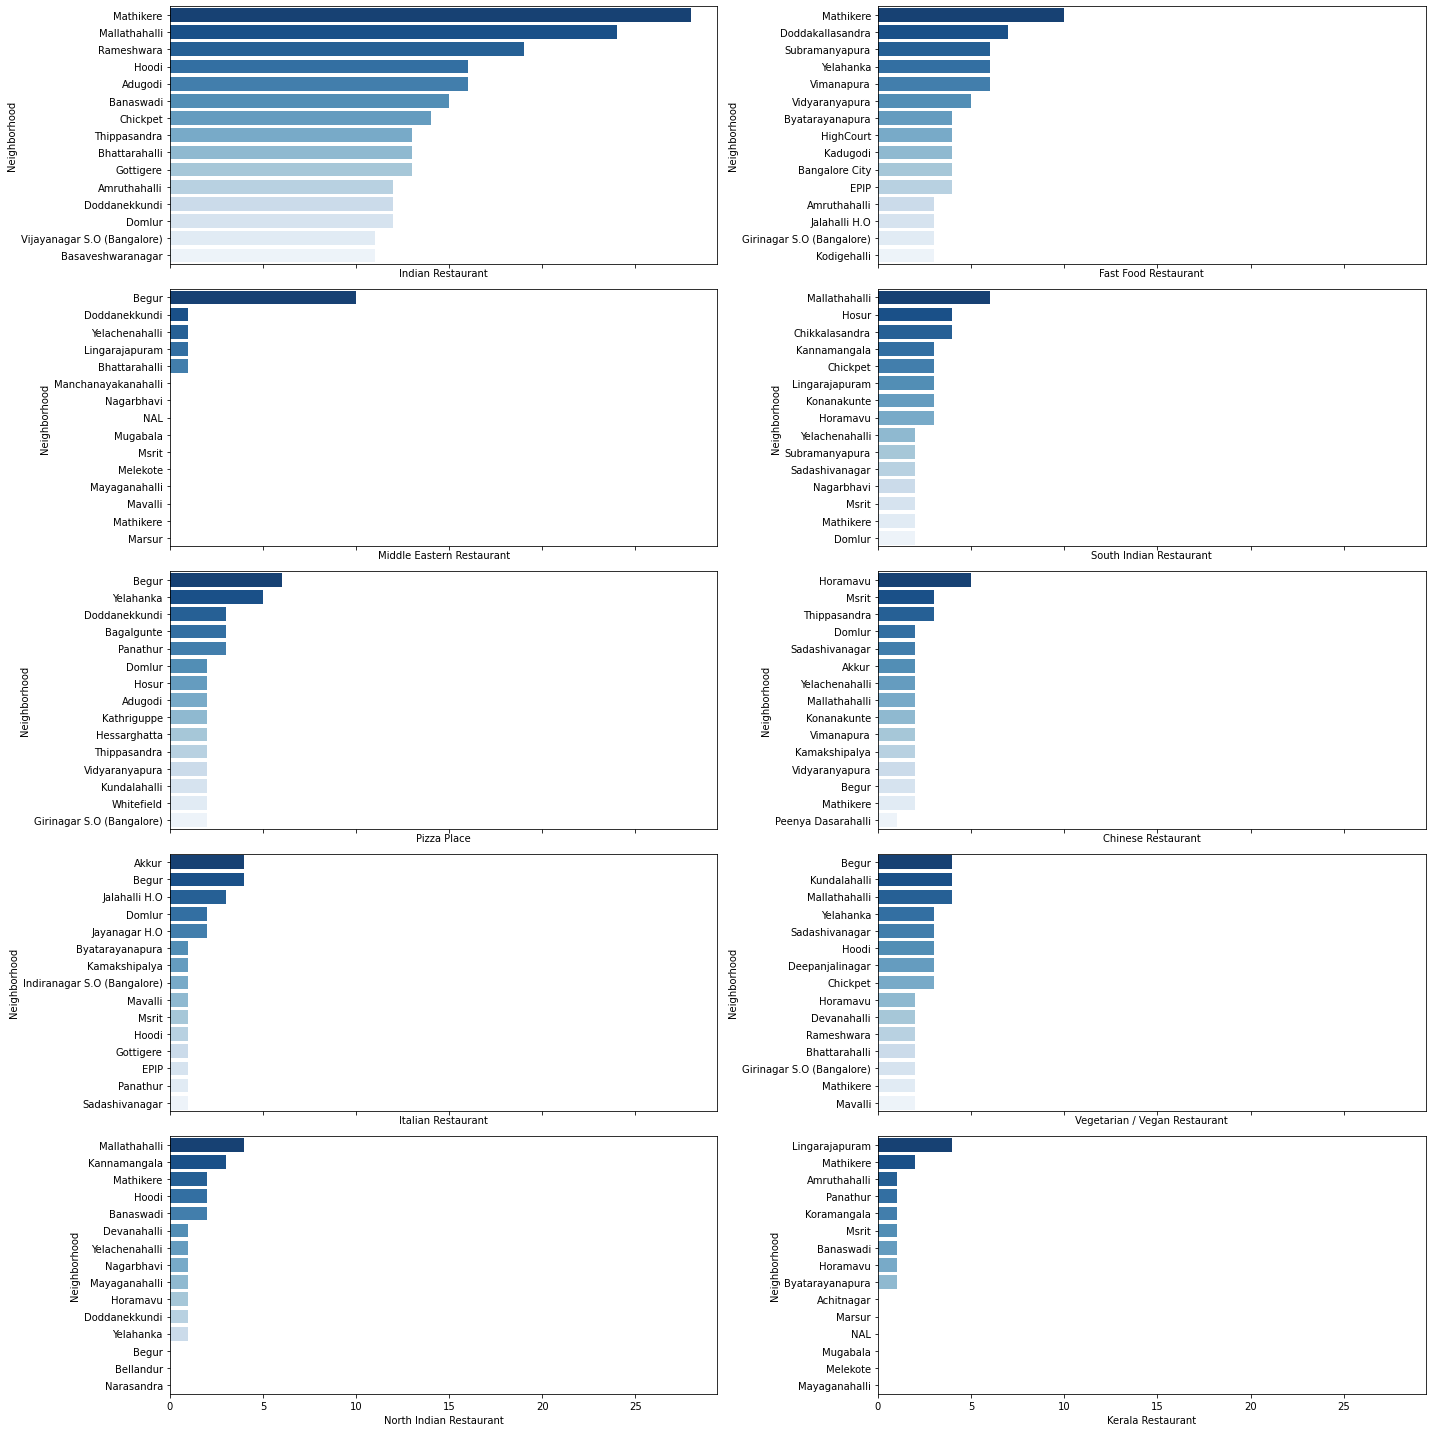

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes =plt.subplots(5, 2, figsize=(20,20), sharex=True)
axes = axes.flatten()

for ax, category in zip(axes, venue_top15_list):
    data = venue_counts[[category]].sort_values([category], ascending=False)[0:15]
    pal = sns.color_palette("Blues", len(data))
    sns.barplot(x=category, y=data.index, data=data, ax=ax, palette=np.array(pal[::-1]))

plt.tight_layout()
plt.show();

__Grouping rows by neighborhood and by taking the mean of the frequency of occurrence of each category__

In [77]:
blr_grouped = blr_onehot.groupby('Neighborhood').mean().reset_index()
blr_grouped.head()

,Neighborhood,Afghan Restaurant,American Restaurant,Andhra Restaurant,Asian Restaurant,Austrian Restaurant,BBQ Joint,Belgian Restaurant,Brewery,Burmese Restaurant,Burrito Place,Cantonese Restaurant,Caribbean Restaurant,Chaat Place,Chettinad Restaurant,Chinese Restaurant,Dhaba,Doner Restaurant,Dumpling Restaurant,Falafel Restaurant,Fast Food Restaurant,French Restaurant,Fried Chicken Joint,Friterie,German Restaurant,Halal Restaurant,Hyderabadi Restaurant,Indian Chinese Restaurant,Indian Restaurant,Indian Sweet Shop,Italian Restaurant,Japanese Restaurant,Karnataka Restaurant,Kebab Restaurant,Kerala Restaurant,Korean Restaurant,Lebanese Restaurant,Maharashtrian Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Moroccan Restaurant,Motorcycle Shop,Mughlai Restaurant,Multicuisine Indian Restaurant,Noodle House,North Indian Restaurant,Northeast Indian Restaurant,Pet Service,Pizza Place,Punjabi Restaurant,Rajasthani Restaurant,Scandinavian Restaurant,Seafood Restaurant,Shopping Mall,South Indian Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Steakhouse,Sushi Restaurant,Szechuan Restaurant,Thai Restaurant,Tibetan Restaurant,Turkish Coffeehouse,Turkish Restaurant,Udupi Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Yemeni Restaurant
0,Achitnagar,0.0,0.000000,0.000000,0.200000,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.400000,0.0,0.000000,0.000,0.0,0.0,0.0,0.0,0.400000,0.000000,0.00,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
1,Adugodi,0.0,0.000000,0.000000,0.000000,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.035714,0.000000,0.0,0.0,0.0,0.035714,0.0,0.000000,0.000,0.0,0.0,0.0,0.0,0.571429,0.000000,0.00,0.000000,0.000000,0.0,0.000000,0.0,0.035714,0.0,0.0,0.035714,0.0,0.0,0.0,0.0,0.0,0.0,0.035714,0.0,0.0,0.0,0.071429,0.0,0.035714,0.0,0.035714,0.035714,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.035714,0.0,0.035714,0.0,0.0
2,Agram,0.0,0.153846,0.000000,0.076923,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.076923,0.000000,0.0,0.0,0.0,0.153846,0.0,0.000000,0.000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00,0.076923,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.230769,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.153846,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.076923,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
3,Akkur,0.0,0.000000,0.000000,0.125000,0.0,0.125,0.125,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.125000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.125,0.0,0.0,0.0,0.0,0.000000,0.000000,0.25,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.125000,0.0,0.000000,0.0,0.0
4,Amruthahalli,0.0,0.000000,0.068966,0.034483,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.034483,0.0,0.000000,0.034483,0.0,0.0,0.0,0.103448,0.0,0.034483,0.000,0.0,0.0,0.0,0.0,0.413793,0.034483,0.00,0.000000,0.068966,0.0,0.034483,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.068966,0.0,0.034483,0.0,0.000000,0.000000,0.034483,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0


In [80]:
#new size of dataframe blr_grouped
blr_grouped.shape

(100, 70)

In [0]:
#sorting venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

__Creating new dataframe to display the top 5 venues for each neighborhood__

In [0]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))  

In [0]:
# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = blr_grouped['Neighborhood']

In [84]:
for ind in np.arange(blr_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(blr_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Achitnagar,Fast Food Restaurant,Indian Restaurant,Asian Restaurant,Yemeni Restaurant,Halal Restaurant
1,Adugodi,Indian Restaurant,Pizza Place,Lebanese Restaurant,Rajasthani Restaurant,Fast Food Restaurant
2,Agram,Mediterranean Restaurant,Pizza Place,American Restaurant,Fast Food Restaurant,Japanese Restaurant
3,Akkur,Italian Restaurant,Turkish Restaurant,Asian Restaurant,BBQ Joint,Belgian Restaurant
4,Amruthahalli,Indian Restaurant,Fast Food Restaurant,Andhra Restaurant,Pizza Place,Karnataka Restaurant


###Clustering Neighborhoods

In [0]:
blr_grouped_clustering = blr_grouped.drop('Neighborhood', 1)

__Determine the optimal number of clusters for k-means clustering using Silhouette Method__

In [87]:
from sklearn.metrics import silhouette_score

sil = []
K_sil = range(2,50)
# minimum 2 clusters required, to define dissimilarity
for k in K_sil:
    print(k, end=' ')
    kmeans = KMeans(n_clusters = k).fit(blr_grouped_clustering)
    labels = kmeans.labels_
    sil.append(silhouette_score(blr_grouped_clustering, labels, metric = 'euclidean'))

2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

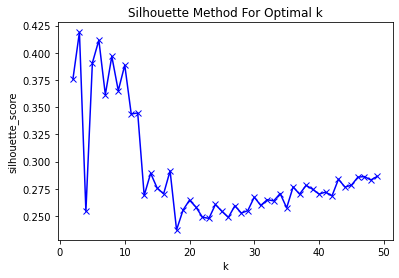

In [88]:
plt.plot(K_sil, sil, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette_score')
plt.title('Silhouette Method For Optimal k')
plt.show()

__At k=2 and k=6 there is peak. Let's use k=6__

In [89]:
# set number of clusters
kclusters = 6

# run k-means clustering
kmeans = KMeans(init="k-means++", n_clusters=kclusters, n_init=50).fit(blr_grouped_clustering)

print(Counter(kmeans.labels_))

Counter({3: 61, 0: 14, 2: 12, 4: 5, 1: 5, 5: 3})


Let's create a new dataframe that includes the cluster as well as the top 5 venues for each neighborhood.

In [0]:
# add clustering labels
try:
    neighborhoods_venues_sorted.drop('Cluster Labels', axis=1)
except:
    neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [91]:
neighborhoods_venues_sorted.head(5)

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,3,Achitnagar,Fast Food Restaurant,Indian Restaurant,Asian Restaurant,Yemeni Restaurant,Halal Restaurant
1,3,Adugodi,Indian Restaurant,Pizza Place,Lebanese Restaurant,Rajasthani Restaurant,Fast Food Restaurant
2,0,Agram,Mediterranean Restaurant,Pizza Place,American Restaurant,Fast Food Restaurant,Japanese Restaurant
3,0,Akkur,Italian Restaurant,Turkish Restaurant,Asian Restaurant,BBQ Joint,Belgian Restaurant
4,3,Amruthahalli,Indian Restaurant,Fast Food Restaurant,Andhra Restaurant,Pizza Place,Karnataka Restaurant


In [93]:
# merge neighborhoods_venues_sorted with blr_data to add latitude/longitude for each neighborhood
blr_merged = neighborhoods_venues_sorted.join(blr_df.set_index('Neighborhood'), on='Neighborhood')
blr_merged.head()

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Latitude,Longitude
0,3,Achitnagar,Fast Food Restaurant,Indian Restaurant,Asian Restaurant,Yemeni Restaurant,Halal Restaurant,13.091176,77.483482
1,3,Adugodi,Indian Restaurant,Pizza Place,Lebanese Restaurant,Rajasthani Restaurant,Fast Food Restaurant,12.942847,77.610416
2,0,Agram,Mediterranean Restaurant,Pizza Place,American Restaurant,Fast Food Restaurant,Japanese Restaurant,45.813177,15.977048
3,0,Akkur,Italian Restaurant,Turkish Restaurant,Asian Restaurant,BBQ Joint,Belgian Restaurant,50.733978,5.666767
3,0,Akkur,Italian Restaurant,Turkish Restaurant,Asian Restaurant,BBQ Joint,Belgian Restaurant,50.733978,5.666767


__Creating a Map for Visualization__

In [95]:
map_clusters = folium.Map(location=[12.97, 77.58], zoom_start=10)

# set color scheme for the clusters
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(blr_merged['Latitude'], blr_merged['Longitude'], blr_merged['Neighborhood'], blr_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 5. Results

In [0]:
required_column_indices = [2,3,7]
required_column = [list(blr_merged.columns.values)[i] for i in required_column_indices]
required_column_indices = [2,3,7]

__Cluster 0__

In [98]:
cluster_0 = blr_merged.loc[blr_merged['Cluster Labels'] == 0, blr_merged.columns[1:12]]
cluster_0.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Latitude,Longitude
2,Agram,Mediterranean Restaurant,Pizza Place,American Restaurant,Fast Food Restaurant,Japanese Restaurant,45.813177,15.977048
3,Akkur,Italian Restaurant,Turkish Restaurant,Asian Restaurant,BBQ Joint,Belgian Restaurant,50.733978,5.666767
3,Akkur,Italian Restaurant,Turkish Restaurant,Asian Restaurant,BBQ Joint,Belgian Restaurant,50.733978,5.666767
6,Arudi,French Restaurant,Yemeni Restaurant,Halal Restaurant,Falafel Restaurant,Fast Food Restaurant,43.105016,-0.427943
10,Bangalore City,Fast Food Restaurant,Punjabi Restaurant,Andhra Restaurant,Chaat Place,Indian Restaurant,13.021626,77.766180


In [99]:
for col in required_column:
    print(cluster_0[col].value_counts(ascending = False))
    print("---------------------------------------------")

Fast Food Restaurant         5
Karnataka Restaurant         3
Italian Restaurant           2
Middle Eastern Restaurant    2
Mediterranean Restaurant     1
Dhaba                        1
BBQ Joint                    1
French Restaurant            1
Turkish Coffeehouse          1
Maharashtrian Restaurant     1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Pizza Place             3
Yemeni Restaurant       3
Andhra Restaurant       3
Turkish Restaurant      2
Punjabi Restaurant      2
Seafood Restaurant      1
Fried Chicken Joint     1
Fast Food Restaurant    1
Indian Restaurant       1
Halal Restaurant        1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
 13.215192    3
 50.733978    2
 52.480709    2
 13.021626    2
 13.100698    1
 13.018496    1
 12.878617    1
 43.105016    1
-0.302997     1
 13.006034    1
 45.813177    1
 38.358493    1
 12.945401    1
Name: Latitude, dtype: int64
-----------------

__Cluster 1__

In [101]:
cluster_1 = blr_merged.loc[blr_merged['Cluster Labels'] == 1, blr_merged.columns[1:12]]
cluster_1.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Latitude,Longitude
16,Byagadadenahalli,Pizza Place,Halal Restaurant,Falafel Restaurant,Fast Food Restaurant,French Restaurant,12.742629,77.701482
39,Hulimangala,Pizza Place,Halal Restaurant,Falafel Restaurant,Fast Food Restaurant,French Restaurant,12.818896,77.638404
60,Laggere,Pizza Place,Halal Restaurant,Falafel Restaurant,Fast Food Restaurant,French Restaurant,13.010868,77.520730
73,NAL,Pizza Place,Halal Restaurant,Falafel Restaurant,Fast Food Restaurant,French Restaurant,58.318956,12.266015
96,Whitefield,Pizza Place,Chinese Restaurant,Dumpling Restaurant,Falafel Restaurant,Fast Food Restaurant,44.373441,-71.610260


In [102]:
for col in required_column:
    print(cluster_1[col].value_counts(ascending = False))
    print("---------------------------------------------")

Pizza Place    5
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Halal Restaurant      4
Chinese Restaurant    1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
12.818896    1
12.742629    1
44.373441    1
58.318956    1
13.010868    1
Name: Latitude, dtype: int64
---------------------------------------------


__Cluster 2__

In [103]:
cluster_2 = blr_merged.loc[blr_merged['Cluster Labels'] == 2, blr_merged.columns[1:12]]
cluster_2.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Latitude,Longitude
5,Anekal,Indian Restaurant,Yemeni Restaurant,Halal Restaurant,Falafel Restaurant,Fast Food Restaurant,12.708637,77.699397
21,Chunchanakuppe,Indian Restaurant,Yemeni Restaurant,Halal Restaurant,Falafel Restaurant,Fast Food Restaurant,12.909558,77.386642
30,Gottigere,Indian Restaurant,Chinese Restaurant,Italian Restaurant,Seafood Restaurant,BBQ Joint,12.856532,77.587724
42,Jakkur,Indian Restaurant,Yemeni Restaurant,Halal Restaurant,Falafel Restaurant,Fast Food Restaurant,13.078474,77.606894
45,Jigani,Indian Restaurant,Karnataka Restaurant,Yemeni Restaurant,German Restaurant,Falafel Restaurant,12.785253,77.638093


In [107]:
for col in required_column:
    print(cluster_2[col].value_counts(ascending = False))
    print("---------------------------------------------")

Indian Restaurant    12
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Yemeni Restaurant       10
Chinese Restaurant       1
Karnataka Restaurant     1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
12.856532    1
13.064294    1
12.708637    1
15.415452    1
13.190571    1
12.909558    1
13.118767    1
12.785253    1
13.078474    1
12.832809    1
13.147862    1
12.789855    1
Name: Latitude, dtype: int64
---------------------------------------------


__Cluster 3__

In [106]:
cluster_3 = blr_merged.loc[blr_merged['Cluster Labels'] == 3, blr_merged.columns[1:12]]
cluster_3.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Latitude,Longitude
0,Achitnagar,Fast Food Restaurant,Indian Restaurant,Asian Restaurant,Yemeni Restaurant,Halal Restaurant,13.091176,77.483482
1,Adugodi,Indian Restaurant,Pizza Place,Lebanese Restaurant,Rajasthani Restaurant,Fast Food Restaurant,12.942847,77.610416
4,Amruthahalli,Indian Restaurant,Fast Food Restaurant,Andhra Restaurant,Pizza Place,Karnataka Restaurant,13.066513,77.596624
7,Attibele,South Indian Restaurant,Indian Restaurant,Yemeni Restaurant,German Restaurant,Falafel Restaurant,12.778259,77.771283
8,Bagalgunte,Indian Restaurant,Fast Food Restaurant,Pizza Place,Falafel Restaurant,Asian Restaurant,13.056649,77.504822


In [108]:
for col in required_column:
    print(cluster_3[col].value_counts(ascending = False))
    print("---------------------------------------------")

Indian Restaurant          54
Fast Food Restaurant        8
North Indian Restaurant     1
South Indian Restaurant     1
Dhaba                       1
Karnataka Restaurant        1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Fast Food Restaurant             17
Indian Restaurant                11
Vegetarian / Vegan Restaurant    10
South Indian Restaurant           6
Pizza Place                       6
Chinese Restaurant                5
Asian Restaurant                  3
Karnataka Restaurant              2
North Indian Restaurant           1
Punjabi Restaurant                1
Italian Restaurant                1
Japanese Restaurant               1
Kerala Restaurant                 1
Chaat Place                       1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
13.003167    3
12.961067    2
13.032888    2
12.798851    1
12.897971    1
12.986475    1
12.952848    1
13.443987    1
12.935146    1
12.99

__Cluster 4__

In [109]:
cluster_4 = blr_merged.loc[blr_merged['Cluster Labels'] == 4, blr_merged.columns[1:12]]
cluster_4.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Latitude,Longitude
13,Bellandur,Fast Food Restaurant,Yemeni Restaurant,Halal Restaurant,Falafel Restaurant,French Restaurant,58.235358,26.683116
34,HighCourt,Fast Food Restaurant,Pizza Place,Halal Restaurant,Falafel Restaurant,French Restaurant,53.783508,-0.387187
82,Rajanakunte,Fast Food Restaurant,Yemeni Restaurant,Halal Restaurant,Falafel Restaurant,French Restaurant,13.169190,77.563944
85,Sarjapura,Fast Food Restaurant,Yemeni Restaurant,Halal Restaurant,Falafel Restaurant,French Restaurant,12.860087,77.786135
86,Shanthinagar,Fast Food Restaurant,Yemeni Restaurant,Halal Restaurant,Falafel Restaurant,French Restaurant,58.235358,26.683116


In [110]:
for col in required_column:
    print(cluster_4[col].value_counts(ascending = False))
    print("---------------------------------------------")

Fast Food Restaurant    5
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Yemeni Restaurant    4
Pizza Place          1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
58.235358    2
13.169190    1
53.783508    1
12.860087    1
Name: Latitude, dtype: int64
---------------------------------------------


__Cluster 5__

In [111]:
cluster_5 = blr_merged.loc[blr_merged['Cluster Labels'] == 5, blr_merged.columns[1:12]]
cluster_5.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Latitude,Longitude
24,Dobbespet,Vegetarian / Vegan Restaurant,Karnataka Restaurant,Yemeni Restaurant,Halal Restaurant,Falafel Restaurant,13.230746,77.242546
31,Hadonahalli,Vegetarian / Vegan Restaurant,Yemeni Restaurant,Halal Restaurant,Falafel Restaurant,Fast Food Restaurant,13.369242,77.544955
70,Melekote,Karnataka Restaurant,Yemeni Restaurant,Halal Restaurant,Falafel Restaurant,Fast Food Restaurant,12.557066,77.415193


In [112]:
for col in required_column:
    print(cluster_5[col].value_counts(ascending = False))
    print("---------------------------------------------")

Vegetarian / Vegan Restaurant    2
Karnataka Restaurant             1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Yemeni Restaurant       2
Karnataka Restaurant    1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
12.557066    1
13.369242    1
13.230746    1
Name: Latitude, dtype: int64
---------------------------------------------


## Thank You
